In [174]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
from modules.ml_logic.preprocessing import create_features_preprocessor, preprocess_features, preprocess_features_transform_only
from modules.ml_logic.model import initialize_model, compile_model, train_model, evaluate_model
from modules.ml_logic.utils import import_data_array, get_average_temperature_per_tile

from modules.ml_logic.utils import get_sub_tiles

from modules.data_aggregation.satellite_data import import_gdf_from_shp

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import pandas as pd
import numpy as np

from sklearn import set_config; set_config(display='diagram')

import matplotlib.pyplot as plt
import seaborn as sns

from modules.ml_logic.utils import get_corners
from shapely.geometry import Polygon, Point

import geopandas
import contextily as ctx

# Checking for missing building data

In [176]:
df = pd.read_csv("../../data/processed_data/Paris/correct_paris_with_building.csv")
df.sample(5)

,Unnamed: 0,LST,ele,LST_diff,ele_diff,ul_corner,ll_corner,lr_corner,ur_corner,bb,building_coverage,av_building_height
25853,25853,24.029999,67.096810,-6.775970,-6.664833,"[[2.357131715703942, 48.877426077920816]]","[[2.357131715703942, 48.87805564415717]]","[[2.357761281940295, 48.87805564415717]]","[[2.357761281940295, 48.877426077920816]]","[[2.357131715703942, 48.877426077920816], [2.3...",0.786828,19.023629
14317,14317,32.389984,78.615170,1.584015,4.853531,"[[2.392387424939707, 48.84846603104858]]","[[2.392387424939707, 48.849095597284936]]","[[2.3930169911760597, 48.849095597284936]]","[[2.3930169911760597, 48.84846603104858]]","[[2.392387424939707, 48.84846603104858], [2.39...",0.071271,18.000000
22590,22590,31.070007,71.059480,0.264038,-2.702164,"[[2.365316076776531, 48.86924171684822]]","[[2.365316076776531, 48.86987128308458]]","[[2.365945643012884, 48.86987128308458]]","[[2.365945643012884, 48.86924171684822]]","[[2.365316076776531, 48.86924171684822], [2.36...",0.000000,0.000000
20709,20709,34.230010,52.273968,3.424042,-21.487675,"[[2.2916568271232363, 48.864834753193755]]","[[2.2916568271232363, 48.86546431943011]]","[[2.292286393359589, 48.86546431943011]]","[[2.292286393359589, 48.864834753193755]]","[[2.2916568271232363, 48.864834753193755], [2....",0.024526,17.799961
16154,16154,37.730010,47.611180,6.924042,-26.150463,"[[2.279695068632531, 48.853502560939404]]","[[2.279695068632531, 48.85413212717576]]","[[2.280324634868884, 48.85413212717576]]","[[2.280324634868884, 48.853502560939404]]","[[2.279695068632531, 48.853502560939404], [2.2...",0.319521,19.727332


<AxesSubplot: xlabel='ele_diff', ylabel='Count'>

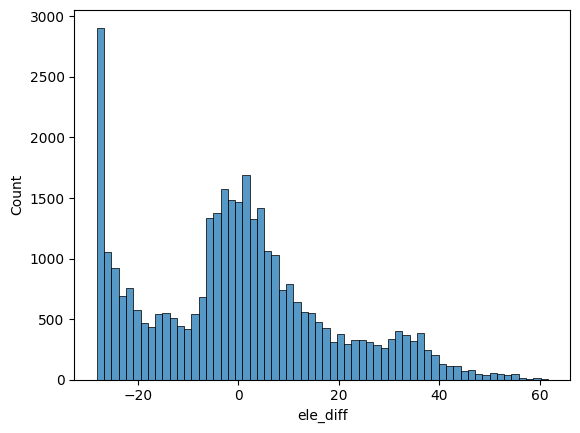

In [177]:
sns.histplot(df.ele_diff)

<AxesSubplot: xlabel='av_building_height', ylabel='Count'>

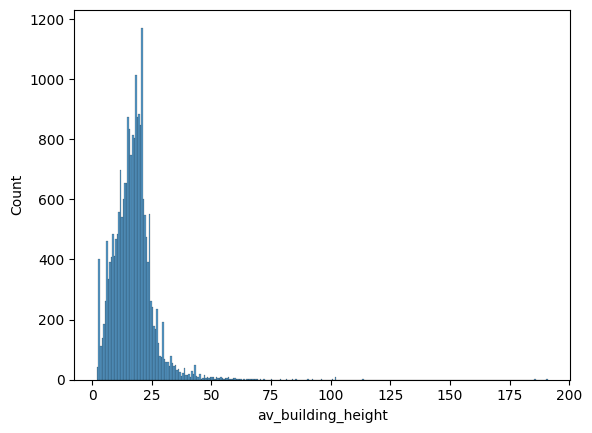

In [178]:
sns.histplot(df.av_building_height[df.av_building_height >= .001])

<AxesSubplot: xlabel='building_coverage', ylabel='Count'>

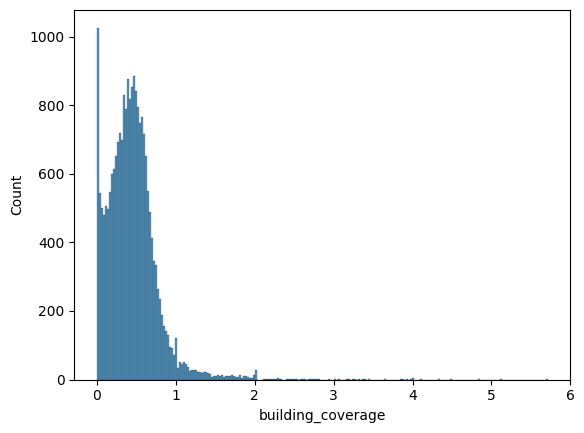

In [179]:
sns.histplot(df.building_coverage[df.building_coverage >= .001])

In [180]:
df.sample(5)

,Unnamed: 0,LST,ele,LST_diff,ele_diff,ul_corner,ll_corner,lr_corner,ur_corner,bb,building_coverage,av_building_height
3805,3805,26.750000,49.350880,-4.055969,-24.410763,"[[2.279065502396178, 48.82265381535811]]","[[2.279065502396178, 48.823283381594464]]","[[2.279695068632531, 48.823283381594464]]","[[2.279695068632531, 48.82265381535811]]","[[2.279065502396178, 48.82265381535811], [2.27...",0.000000,0.000000
32128,32128,31.350006,93.528760,0.544037,19.767120,"[[2.3413925597951186, 48.893165233829635]]","[[2.3413925597951186, 48.89379480006599]]","[[2.3420221260314715, 48.89379480006599]]","[[2.3420221260314715, 48.893165233829635]]","[[2.3413925597951186, 48.893165233829635], [2....",0.243038,13.161302
22198,22198,35.389984,76.026420,4.584015,2.264778,"[[2.2771768036871185, 48.868612150611874]]","[[2.2771768036871185, 48.86924171684823]]","[[2.2778063699234714, 48.86924171684823]]","[[2.2778063699234714, 48.868612150611874]]","[[2.2771768036871185, 48.868612150611874], [2....",0.000000,0.000000
14355,14355,29.809998,110.455780,-0.995972,36.694138,"[[2.416310941921119, 48.84846603104858]]","[[2.416310941921119, 48.849095597284936]]","[[2.416940508157472, 48.849095597284936]]","[[2.416940508157472, 48.84846603104858]]","[[2.416310941921119, 48.84846603104858], [2.41...",0.000000,0.000000
1410,1410,29.350006,45.873096,-1.455963,-27.888546,"[[2.357761281940295, 48.81635815299458]]","[[2.357761281940295, 48.81698771923094]]","[[2.358390848176648, 48.81698771923094]]","[[2.358390848176648, 48.81635815299458]]","[[2.357761281940295, 48.81635815299458], [2.35...",0.061303,32.000000


In [181]:
from ast import literal_eval

In [182]:
df_red = df.drop(columns=['LST', 'ele','ll_corner', 'ur_corner', 'lr_corner','bb'])

# convert str to list
df_red['ul_corner'] = df_red.ul_corner.apply(literal_eval)

In [183]:
df_red.drop(columns='Unnamed: 0', inplace=True)

In [184]:
df_red['lon'] = np.array([row[0] for row in df_red.ul_corner])[:,0]
df_red['lat'] = np.array([row[0] for row in df_red.ul_corner])[:,1]

    # set lon, lat as index and unstack
# data_coord_array = 
data_coord_df = df_red.set_index(['lon', 'lat']).unstack()

In [185]:
# group by latitude and get mean of building coverage
build_den = pd.DataFrame(df_red.groupby(by='lat')['building_coverage'].mean().sort_index()).reset_index()

In [186]:
df_red.set_index(['lon','lat']).unstack()

LST_diff                                                    \
lat      48.813210 48.813840 48.814469 48.815099 48.815729 48.816358   
lon                                                                    
2.263326 -2.315979 -2.795959 -2.795959 -2.675964 -3.515961 -2.795959   
2.263956 -2.255981 -1.695984 -2.835968 -4.175964 -4.175964 -2.795959   
2.264585 -2.355957 -2.835968 -2.335968 -3.575958 -4.395966 -4.395966   
2.265215 -1.575958 -1.755981 -3.475983 -3.755981 -3.435974 -4.175964   
2.265845 -2.915985 -3.135956 -3.555969 -3.755981 -3.795959 -4.135956   
...            ...       ...       ...       ...       ...       ...   
2.418829  0.604034  1.604034  3.344025  1.924042  1.564026  2.424042   
2.419459  1.604034  2.204041  2.204041  1.004028  1.564026  2.564026   
2.420088  0.184021  0.544037  1.004028  1.004028  1.324036  2.564026   
2.420718  0.184021  0.544037  0.564026  0.284027  2.044037  2.044037   
2.421347  1.344025  1.464020  0.564026  0.284027  1.064026  2.164032   

                                                  ... av_building_height  \
lat      48.816988 48.817617 48.818247 48.818876  ...          48.894424   
lon                                               ...                      
2.263326 -3.975983 -3.935974 -3.595978 -1.735962  ...          24.000000   
2.263956 -3.975983 -3.235962 -3.615967 -1.735962  ...          11.893405   
2.264585 -3.895966 -3.235962 -3.615967 -4.255981  ...          15.059733   
2.265215 -3.495972 -3.495972 -3.835968 -4.255981  ...          19.132593   
2.265845 -4.275970 -3.835968 -3.835968 -4.955963  ...          20.158753   
...            ...       ...       ...       ...  ...                ...   
2.418829  2.264038  2.604034  1.604034  1.764038  ...          12.383928   
2.419459  2.504028  2.164032  1.604034  0.984039  ...           6.636510   
2.420088  2.504028  3.004028  1.584015  0.524017  ...           6.455743   
2.420718  2.164032  3.004028  1.584015 -0.295959  ...          17.460637   
2.421347  2.324036  2.324036  0.344025 -0.295959  ...          21.083971   

                                                                           \
lat       48.895054 48.895683  48.896313  48.896943  48.897572  48.898202   
lon                                                                         
2.263326   0.000000       0.0   0.000000  19.642337  11.574574  11.499450   
2.263956   0.000000       0.0   0.000000  20.158480  20.744484  13.444221   
2.264585  12.019176       0.0   0.000000  18.993733  22.876516  17.259136   
2.265215  15.771823       0.0   0.000000   7.014903   9.536818  21.836219   
2.265845  21.000000       0.0   0.000000   0.000000   9.757536  14.755960   
...             ...       ...        ...        ...        ...        ...   
2.418829  21.760622       0.0  16.000000  16.000000   0.000000   0.000000   
2.419459  16.492008       7.7   7.286537  16.000000   0.000000   0.000000   
2.420088  24.259192       7.7   7.680964  16.000000   0.000000   0.000000   
2.420718  22.758541       7.7   7.644996  12.497654   5.800000   0.000000   
2.421347  22.633763       7.7   7.738618   5.800000   9.952233   8.200000   

                                           
lat       48.898831  48.899461  48.900090  
lon                                        
2.263326  13.177759  18.964676  17.535814  
2.263956  14.569154  18.233787  17.524587  
2.264585  18.224148  19.369521  22.584094  
2.265215  23.056681  18.448249  15.288559  
2.265845  17.588468  12.320072  15.609283  
...             ...        ...        ...  
2.418829   0.000000  14.400000  14.400000  
2.419459   0.000000  14.400000  14.400000  
2.420088   0.000000  14.400000  14.400000  
2.420718   0.000000  14.400000  16.867726  
2.421347   0.000000  19.200000  18.151602  

[252 rows x 695 columns]

In [187]:
# dim: 252 (lon) x 139 (lat)

In [188]:
leave_out = [15:22], [49:54], [84:91], [118:125]
# 15, 27, 30, 27, 13 -> max lat_px_num = 13, 15 -> maybe 6

SyntaxError: invalid syntax (2925485811.py, line 1)

In [ ]:
build_den.iloc[15, :].lat, build_den.iloc[23, :].lat

(48.82265381535811, 48.82769034524893)

In [ ]:
def get_zero_buildings_lat_range(df):
    
    df_red = df.drop(columns=['LST', 'ele','ll_corner', 'ur_corner', 'lr_corner','bb'])

    # convert str to list
    df_red['ul_corner'] = df_red.ul_corner.apply(literal_eval)
    
    # drop irrelevant index
    df_red.drop(columns='Unnamed: 0', inplace=True)
    
    # get lon, lat of ul corner
    df_red['lon'] = np.array([row[0] for row in df_red.ul_corner])[:,0]
    df_red['lat'] = np.array([row[0] for row in df_red.ul_corner])[:,1]

    # group by latitude and get mean of building coverage
    build_den = pd.DataFrame(df_red.groupby(by='lat')['building_coverage'].mean().sort_index()).reset_index()
    
    # get every averaged lon row close to zero
    build_zero = build_den[build_den.building_coverage <= .005]
    
    #
    

In [ ]:
build_zero.loc[16, :]

lat                  48.823283
building_coverage     0.000000
Name: 16, dtype: float64

In [ ]:
list(np.arange(390))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
build_zero= build_den[build_den.building_coverage <= .005]
build_zero

,lat,building_coverage
15,48.822654,0.000000
16,48.823283,0.000000
17,48.823913,0.000000
18,48.824543,0.000000
19,48.825172,0.000000
20,48.825802,0.000000
21,48.826431,0.000000
22,48.827061,0.000274
49,48.844059,0.000938
50,48.844689,0.000000


In [ ]:
build_zero.index[-1]+1

126

In [ ]:
build_zero.append(build_den.loc[build_zero.index[-1]+1])

/var/folders/lx/wkd07qrn1rl92x3h2lmy3h8c0000gn/T/ipykernel_8867/2834861036.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  build_zero.append(build_den.loc[build_zero.index[-1]+1])


,lat,building_coverage
15,48.822654,0.000000
16,48.823283,0.000000
17,48.823913,0.000000
18,48.824543,0.000000
19,48.825172,0.000000
20,48.825802,0.000000
21,48.826431,0.000000
22,48.827061,0.000274
49,48.844059,0.000938
50,48.844689,0.000000


In [ ]:
build_zero.append(build_den)

In [ ]:
lat_to_drop = [] #[[lat15, lat23], [lat49, lat55], …]
sublist_i = []
start = True

build_zero_plus1 = build_zero.append(build_den.loc[build_zero.index[-1]+1])

for i in np.arange(len(build_zero.index)):
    index_i = build_zero_plus1.index[i]
    index_plus1 = build_zero_plus1.index[i+1]
    
    # apend if  start = True
    if start:
        sublist_i.append(build_zero_plus1.loc[index_i, 'lat'])
        start = False
    
    # append every row
    sublist_i.append(build_zero_plus1.loc[index_i, 'lat'])
    
    # if index[i+1] != index[i]+1, then 
    if index_i + 1 == index_plus1:
        print('same', index_i)
        sublist_i.remove(build_zero_plus1.loc[index_i, 'lat'])
    
    # index[i] + 1  != index[i+1] we want to append index[i] and also index[i]+1 to get the bounds
    else:
        start = True
        lat_to_drop.append(sublist_i)
        
        print('not same', lat_to_drop)
        sublist_i = []
        
        
lat_to_drop

same 15
same 16
same 17
same 18
same 19
same 20
same 21
not same [[48.82265381535811, 48.82706077901258]]
same 49
same 50
same 51
same 52
same 53
not same [[48.82265381535811, 48.82706077901258], [48.844059067394106, 48.84720689857587]]
same 84
same 85
same 86
same 87
same 88
same 89
same 90
not same [[48.82265381535811, 48.82706077901258], [48.844059067394106, 48.84720689857587], [48.86609388566646, 48.87050084932093]]
same 118
same 119
same 120
same 121
same 122
same 123
same 124
same 125


/var/folders/lx/wkd07qrn1rl92x3h2lmy3h8c0000gn/T/ipykernel_8867/1322460021.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  build_zero_plus1 = build_zero.append(build_den.loc[build_zero.index[-1]+1])


[[48.82265381535811, 48.82706077901258],
 [48.844059067394106, 48.84720689857587],
 [48.86609388566646, 48.87050084932093]]

In [ ]:
df.building_coverage.value_counts()

0.000000    12778
1.000000       23
2.000000       17
4.000000        4
1.000000        2
            ...  
0.246553        1
0.246527        1
0.234601        1
0.709792        1
0.913057        1
Name: building_coverage, Length: 22208, dtype: int64

# DL flow

In [ ]:
gdf_Paris_import = import_gdf_from_shp("Paris")

In [ ]:
gdf_Paris_import_build = pd.read_csv('../../data/processed_data/Paris/correct_paris_with_building.csv').drop(columns = "Unnamed: 0")
gdf_Paris_import_build.sample(5)

,LST,ele,LST_diff,ele_diff,ul_corner,ll_corner,lr_corner,ur_corner,bb,building_coverage,av_building_height
12150,28.149994,52.152428,-2.655975,-21.609215,"[[2.2973229232504133, 48.84342950115776]]","[[2.2973229232504133, 48.84405906739411]]","[[2.2979524894867662, 48.84405906739411]]","[[2.2979524894867662, 48.84342950115776]]","[[2.2973229232504133, 48.84342950115776], [2.2...",0.287752,16.382289
18429,30.570007,74.556175,-0.235962,0.794533,"[[2.2841020322870014, 48.859168657066576]]","[[2.2841020322870014, 48.85979822330293]]","[[2.2847315985233543, 48.85979822330293]]","[[2.2847315985233543, 48.859168657066576]]","[[2.2841020322870014, 48.859168657066576], [2....",0.585025,19.895020
16939,33.190002,52.388836,2.384033,-21.372807,"[[2.2979524894867662, 48.855391259648464]]","[[2.2979524894867662, 48.85602082588482]]","[[2.298582055723119, 48.85602082588482]]","[[2.298582055723119, 48.855391259648464]]","[[2.2979524894867662, 48.855391259648464], [2....",0.000000,0.000000
33024,34.850006,83.048060,4.044037,9.286415,"[[2.2708811413235894, 48.89568349877505]]","[[2.2708811413235894, 48.896313065011405]]","[[2.2715107075599423, 48.896313065011405]]","[[2.2715107075599423, 48.89568349877505]]","[[2.2708811413235894, 48.89568349877505], [2.2...",0.054174,9.000000
14402,29.209991,49.151794,-1.595978,-24.609848,"[[2.287249863468766, 48.84909559728493]]","[[2.287249863468766, 48.849725163521285]]","[[2.287879429705119, 48.849725163521285]]","[[2.287879429705119, 48.84909559728493]]","[[2.287249863468766, 48.84909559728493], [2.28...",0.000000,0.000000


In [ ]:
prep_features = preprocess_features(gdf_Paris_import_build)


Preprocess features...
['av_building_height', 'building_coverage', 'ele_diff', 'LST', 'ele', 'LST_diff', 'ul_corner', 'll_corner', 'lr_corner', 'ur_corner', 'bb']


In [ ]:
prep_features

,LST_diff,av_building_height,building_coverage,ele_diff,LST,ele,ul_corner,ll_corner,lr_corner,ur_corner,bb
0,-2.315979,-0.271402,-0.321826,0.0,28.48999,45.57731,"[[2.2633263464873545, 48.81321032181281]]","[[2.2633263464873545, 48.813839888049166]]","[[2.2639559127237074, 48.813839888049166]]","[[2.2639559127237074, 48.81321032181281]]","[[2.2633263464873545, 48.81321032181281], [2.2..."
1,-2.255981,-0.17116,-0.197096,0.000001,28.549988,45.57743,"[[2.2639559127237074, 48.81321032181281]]","[[2.2639559127237074, 48.813839888049166]]","[[2.2645854789600603, 48.813839888049166]]","[[2.2645854789600603, 48.81321032181281]]","[[2.2639559127237074, 48.81321032181281], [2.2..."
2,-2.355957,-0.320733,-0.259066,0.015254,28.450012,46.94714,"[[2.2645854789600603, 48.81321032181281]]","[[2.2645854789600603, 48.813839888049166]]","[[2.2652150451964133, 48.813839888049166]]","[[2.2652150451964133, 48.81321032181281]]","[[2.2645854789600603, 48.81321032181281], [2.2..."
3,-1.575958,0.221291,-0.32307,0.031562,29.230011,48.41168,"[[2.2652150451964133, 48.81321032181281]]","[[2.2652150451964133, 48.813839888049166]]","[[2.265844611432766, 48.813839888049166]]","[[2.265844611432766, 48.81321032181281]]","[[2.2652150451964133, 48.81321032181281], [2.2..."
4,-2.915985,-0.180559,-0.380058,0.034144,27.889984,48.643574,"[[2.265844611432766, 48.81321032181281]]","[[2.265844611432766, 48.813839888049166]]","[[2.266474177669119, 48.813839888049166]]","[[2.266474177669119, 48.81321032181281]]","[[2.265844611432766, 48.81321032181281], [2.26..."
...,...,...,...,...,...,...,...,...,...,...,...
35023,3.344025,0.174834,3.696997,0.245255,34.149994,67.60221,"[[2.4188292068665307, 48.90009046242952]]","[[2.4188292068665307, 48.90072002866587]]","[[2.4194587731028836, 48.90072002866587]]","[[2.4194587731028836, 48.90009046242952]]","[[2.4188292068665307, 48.90009046242952], [2.4..."
35024,2.944031,0.174834,3.696997,0.25617,33.75,68.582405,"[[2.4194587731028836, 48.90009046242952]]","[[2.4194587731028836, 48.90072002866587]]","[[2.4200883393392365, 48.90072002866587]]","[[2.4200883393392365, 48.90009046242952]]","[[2.4194587731028836, 48.90009046242952], [2.4..."
35025,2.944031,0.174834,3.686186,0.25617,33.75,68.582405,"[[2.4200883393392365, 48.90009046242952]]","[[2.4200883393392365, 48.90072002866587]]","[[2.4207179055755894, 48.90072002866587]]","[[2.4207179055755894, 48.90009046242952]]","[[2.4200883393392365, 48.90009046242952], [2.4..."
35026,1.884033,0.306774,1.52468,0.280597,32.690002,70.77612,"[[2.4207179055755894, 48.90009046242952]]","[[2.4207179055755894, 48.90072002866587]]","[[2.4213474718119423, 48.90072002866587]]","[[2.4213474718119423, 48.90009046242952]]","[[2.4207179055755894, 48.90009046242952], [2.4..."


In [199]:

data_array, bb = get_sub_tiles(prep_features, 6, 6)
# export it and bb here
X = data_array[:,:,:,1:].astype('float64')
y = get_average_temperature_per_tile(data_array)

# split into train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

X_train_2, X_test_2 = X[:700], X[700:]
y_train_2, y_test_2 = y[:700], y[700:]

# bb
bb_train, bb_test = bb[:700], bb[700:]

data_array.shape

(943, 6, 6, 4)

<AxesSubplot: ylabel='Count'>

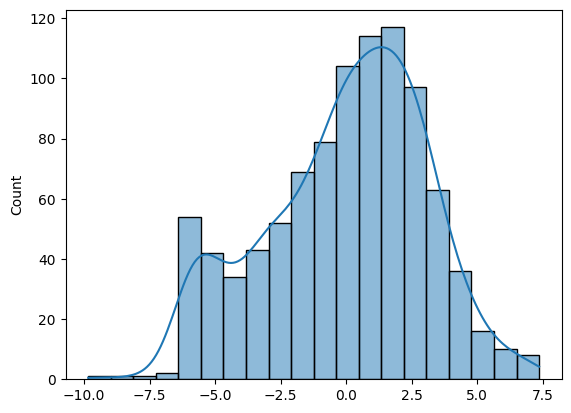

In [201]:
sns.histplot(y, bins = 20, kde = True)

In [202]:
X_train.shape, y_train.shape, X_test.shape, data_array.shape

((660, 6, 6, 3), (660,), (283, 6, 6, 3), (943, 6, 6, 4))

In [358]:
model = initialize_model(X_train.shape[1:])


✅ model initialised


In [359]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 6, 6, 8)           104       
                                                                 
 conv2d_88 (Conv2D)          (None, 5, 5, 16)          528       
                                                                 
 conv2d_89 (Conv2D)          (None, 4, 4, 32)          2080      
                                                                 
 average_pooling2d_33 (Avera  (None, 2, 2, 32)         0         
 gePooling2D)                                                    
                                                                 
 flatten_25 (Flatten)        (None, 128)               0         
                                                                 
 dense_67 (Dense)            (None, 10)                1290      
                                                     

In [360]:
compile_model(model, learning_rate = .005)


✅ model compiled


In [361]:
model, history = train_model(model,
                             X_train,
                             y_train, patience = 5, batch_size=25)


Train model...

✅ model trained (660 rows)


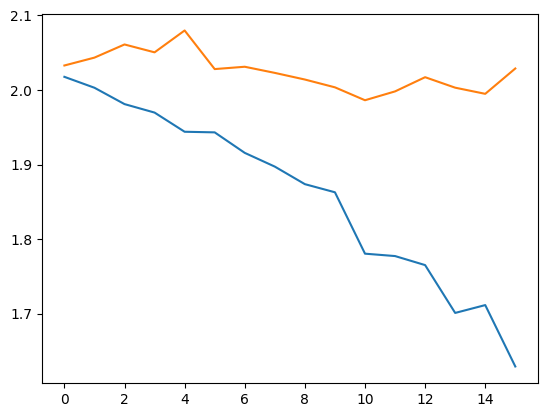

In [362]:
plt.plot(history.history['loss'])
# plt.plot(history.history['mae'])

plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_mae'])

# plt.ylim(0,20)
plt.show()

In [363]:
evaluate_model(model, X_test, y_test)


Evaluate model on 283 rows...
5/5 [==============================] - 0s 2ms/step - loss: 1.9640 - mae: 2.4177

✅ model evaluated: loss 1.96, mae 2.42, baseline mae: 9.32764322293997


{'loss': 1.964046597480774, 'mae': 2.4177026748657227}

In [364]:
y_pred = model.predict(X_test_2)

8/8 [==============================] - 0s 1ms/step


# Visualisation

In [365]:
y_pred.shape

(243, 1)

(28, 2, 2)


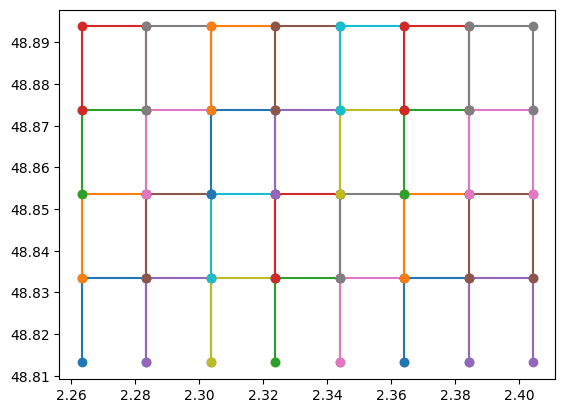

In [366]:
bb_new = get_sub_tiles(prep_features, 32, 32)[1]
print(bb_new.shape)

tiles = np.array([get_corners([bb])[0] for bb in bb_new])
x_tiles = tiles[:,:,0]
y_tiles = tiles[:,:,1]

for i in range(len(bb_new)):
    plt.plot(x_tiles[i], y_tiles[i], marker ="o")

In [367]:
pred_gdf = geopandas.GeoDataFrame(y_pred, geometry = [Polygon(get_corners([bb])[0]) for bb in bb_test])
pred_gdf.columns = ['LST_diff', 'geometry']

In [368]:
pred_gdf['centre_points'] = [pred_gdf.geometry[i].centroid.wkt for i in np.arange(len(pred_gdf))]
pred_gdf

,LST_diff,geometry,centre_points
0,1.338672,"POLYGON ((2.37665 48.85098, 2.37665 48.85476, ...",POINT (2.378536967739942 48.852872994703056)
1,0.446557,"POLYGON ((2.37665 48.85476, 2.37665 48.85854, ...",POINT (2.378536967739942 48.85665039212117)
2,-0.342712,"POLYGON ((2.37665 48.85854, 2.37665 48.86232, ...",POINT (2.378536967739942 48.86042778953929)
3,0.323909,"POLYGON ((2.37665 48.86232, 2.37665 48.86609, ...",POINT (2.378536967739942 48.8642051869574)
4,0.534751,"POLYGON ((2.37665 48.86609, 2.37665 48.86987, ...",POINT (2.378536967739942 48.867982584375525)
...,...,...,...
238,1.141471,"POLYGON ((2.41442 48.88120, 2.41442 48.88498, ...",POINT (2.4163109419211186 48.883092174047995)
239,0.014616,"POLYGON ((2.41442 48.88498, 2.41442 48.88876, ...",POINT (2.4163109419211186 48.88686957146611)
240,0.596207,"POLYGON ((2.41442 48.88876, 2.41442 48.89254, ...",POINT (2.4163109419211186 48.89064696888423)
241,2.296828,"POLYGON ((2.41442 48.89254, 2.41442 48.89631, ...",POINT (2.4163109419211186 48.894424366302346)


In [369]:
pred_gdf.to_file('../../data/processed_data/Paris/Paris_viz.geojson',  driver='GeoJSON')

/Users/bfc/.pyenv/versions/3.10.6/envs/future_proofing_cities/lib/python3.10/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


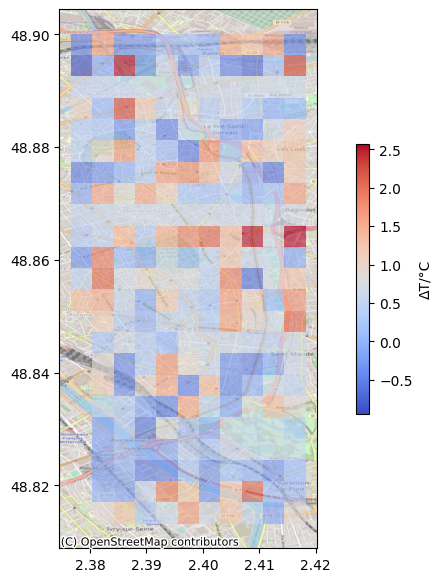

In [370]:
fig, ax = plt.subplots(figsize = (10,7))
pred_gdf.plot(column = 'LST_diff', ax = ax, alpha = .6, cmap = 'coolwarm',\
    legend = True,legend_kwds={'shrink': 0.5, 'label': 'ΔT/°C'})
ctx.add_basemap(ax,  crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

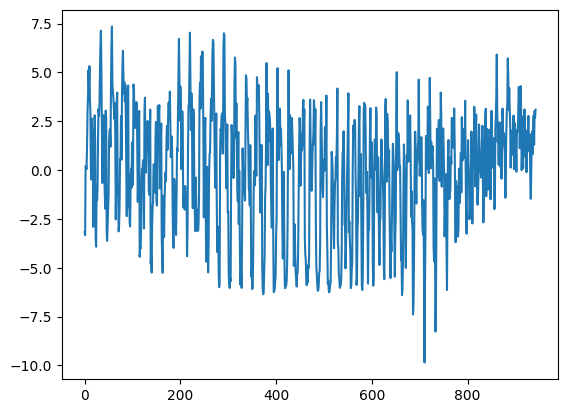

In [316]:
plt.plot(y)